In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

# Distance

The *small-world phenomenon* is, broadly speaking, the observation that any two people in a group can be connected by a surprisingly short path of acquaintances. This concept appears, for instance, in the "Bacon number" game, where actors are nodes, appearing in the same movie creates an edge between them, and one tries to find the distance between Kevin Bacon and some other designated actor. 

The **distance** between two nodes in a connected graph is the number of edges in the shortest path between them. For example, in a complete graph, the distance between any pair of distinct nodes is 1, since all possible pairs are connected by an edge.

In [2]:
K5 = nx.complete_graph(5)
dist = pd.Series(nx.shortest_path_length(K5,0),index=K5.nodes)
print("Distance from node 0:",dist)

Distance from node 0: 0    0
1    1
2    1
3    1
4    1
dtype: int64


The maximum distance over all pairs of nodes in a graph is called its **diameter**. Since this value depends on an extreme outlier in the distribution of distances, we often preferr to use the **average distance** as a measure of how difficult it is to connect two randomly selected nodes.

For example, here is a wheel graph:

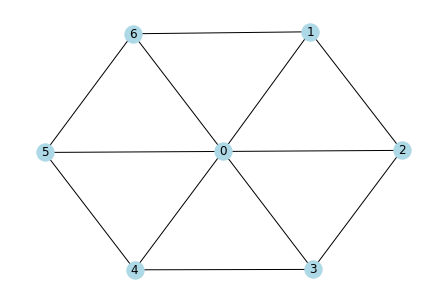

In [3]:
W = nx.wheel_graph(7)
nx.draw(W,with_labels=True,node_color="lightblue")

No node is more than two hops away from another (if the first hop is to node 0), so the diameter of this graph is 2. The average distance is somewhat smaller. This graph is so small that we can easily find the entire matrix of pairwise distances. The matrix is symmetric, so it's only necessary to compute its upper triangle.

In [4]:
nodes = list(W.nodes)
n = len(nodes)
D = np.zeros((n,n),dtype=int)
for i in range(n):
    for j in range(i+1,n):
        D[i,j] = nx.shortest_path_length(W,nodes[i],nodes[j]) 

print(D)

[[0 1 1 1 1 1 1]
 [0 0 1 2 2 2 1]
 [0 0 0 1 2 2 2]
 [0 0 0 0 1 2 2]
 [0 0 0 0 0 1 2]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]]


To get the average distance, we can sum over all the entries and divide by $\binom{n}{2}$:

In [5]:
print("average distance:",2*D.sum()/(n*(n-1)))

average distance: 1.4285714285714286


There is a convenience function for computing this average. (It becomes slow as $n$ grows, though.)

In [6]:
print("average distance:",nx.average_shortest_path_length(W))

average distance: 1.4285714285714286


## ER graphs

If we want to compute distances within ER random graphs, we quickly run into a problem: an ER graph may not have a path between every pair of nodes:

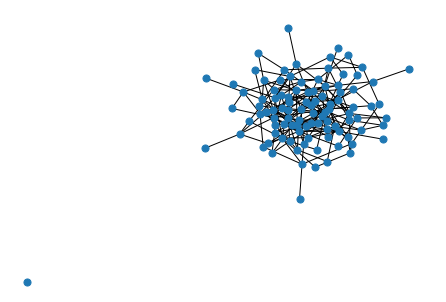

In [7]:
n,p = 101,1/25
ER = nx.erdos_renyi_graph(n,p,seed=0)
nx.draw(ER,node_size=50)

We say that such a graph is not **connected**. When no path exists between two nodes, the distance between them is either undefined or infinite. NetworkX will give an error if we try to compute the average distance in a disconnected graph:

In [8]:
nx.average_shortest_path_length(ER)

NetworkXError: Graph is not connected.

One way to cope with this eventuality is to decompose the graph into **connected components**, a disjoint separation of the nodes into connected subgraphs. We can use `nx.connected_components` to get node sets for each component.

In [9]:
[len(cc) for cc in nx.connected_components(ER)]

[100, 1]

The result above tells us that removing the lone unconnected node in the ER graph leaves us with a connected component. We can always get the largest component with the following idiom:

In [10]:
ER_sub = ER.subgraph( max(nx.connected_components(ER), key=len) )
print(ER_sub.number_of_nodes(),"nodes in largest component")

100 nodes in largest component


Now the average path length is a valid computation.

In [11]:
nx.average_shortest_path_length(ER_sub)

3.3082828282828283

Let's use this method to examine average distances within ER graphs of a fixed type.

average distance in the big component of ER graphs:


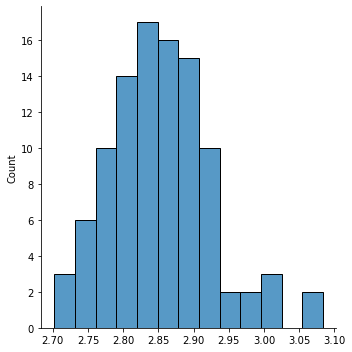

In [12]:
n,p = 121,1/20
dbar = []
for iter in range(100):
    ER = nx.erdos_renyi_graph(n,p,seed=iter+5000)
    ER_sub = ER.subgraph( max(nx.connected_components(ER), key=len) )
    dbar.append(nx.average_shortest_path_length(ER_sub))

print("average distance in the big component of ER graphs:")
sns.displot(x=dbar,bins=13);

The chances are good, therefore, that any message could be passed along in three hops or fewer (within the big component). In fact, theory states that as $n\to\infty$, the mean distance in ER graphs is expected to be approximately 

```{math}
:label: eq-small-world-ERdistance
\frac{\ln(n)}{\ln(\bar{k})}.
```

For $n=121$ and $\bar{k}=6$ as in the experiment above, this value is about 2.68.

## Twitch network

Let's consider distances within the Twitch network.

In [13]:
twitch = nx.read_edgelist("musae_edges.csv",delimiter=',',nodetype=int)
n,e = twitch.number_of_nodes(),twitch.number_of_edges()
kbar = 2*e/n
print(n,"nodes and",e,"edges")
print(f"average degree is {kbar:.3f}")

7126 nodes and 35324 edges
average degree is 9.914


Computing the distances between all pairs of nodes in this graph would take a rather long time, so we will sample some pairs randomly.

Pairwise distances in Twitch graph:
estimated mean = 3.67376


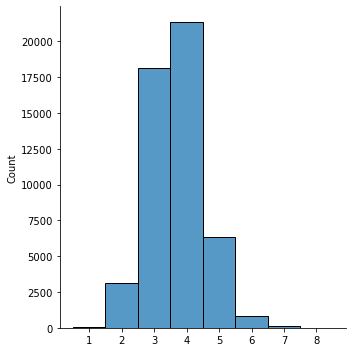

In [14]:
from numpy.random import default_rng
rng = default_rng(1)

# Compute the distance between a random pair of distinct nodes:
def pairdist(G):
    n = nx.number_of_nodes(G)
    i = j = rng.integers(0,n)
    while i==j: j=rng.integers(0,n)   # get distinct nodes
    return nx.shortest_path_length(G,source=i,target=j)

distances = [pairdist(twitch) for _ in range(50000)]
print("Pairwise distances in Twitch graph:")
sns.displot(x=distances,discrete=True)
print("estimated mean =",np.mean(distances))

Let's compare these results to ER graphs with the same size and average degree, i.e., with $p=\bar{k}/(n-1)$. The theoretical estimate from above gives

In [15]:
print("Comparable ER graphs expected mean distance:",np.log(n)/np.log(kbar))

Comparable ER graphs expected mean distance: 3.8673326382368893


The Twitch network might have a slightly stronger small-world effect than a random ER graph, but not dramatically so.

## Watts–Strogatz graphs

The Watts–Strogatz model was originally proposed to explain small-world networks. We use the same $n$ as the Twitch network, and choose $k=10$ to get a similar average degree.

Pairwise distances in WS graphs:


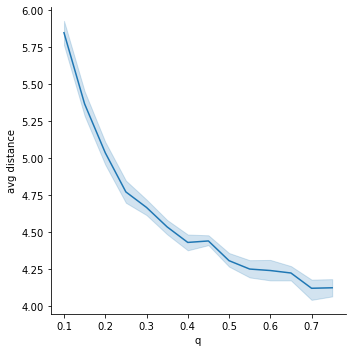

In [16]:
results = []
seed = 44044
n,k = twitch.number_of_nodes(),10
for q in np.arange(0.1,0.76,0.05):
    for iter in range(10):
        WS = nx.watts_strogatz_graph(n,k,q,seed=seed)
        dbar = sum(pairdist(WS) for _ in range(60))/60
        results.append( (q,dbar) )
        seed += 7

results = pd.DataFrame(results,columns=["q","avg distance"])
print("Pairwise distances in WS graphs:")
sns.relplot(data=results,x="q",y="avg distance",kind="line");

We see from the above that pairwise distances decrease as the fraction of rewired edges grows, as we would expect. However, the values here are all well larger than the Twitch mean distance of 3.87, particularly at the value $q=0.42$ that we found in the previous section to match the average clustering. Thus, the Watts-Strogatz model may not be able to explain the Twitch network well. We will confirm that conclusion in the next section.

<div style="max-width:608px"><div style="position:relative;padding-bottom:66.118421052632%"><iframe id="kaltura_player" src="https://cdnapisec.kaltura.com/p/2358381/sp/235838100/embedIframeJs/uiconf_id/43030021/partner_id/2358381?iframeembed=true&playerId=kaltura_player&entry_id=1_ni8nut54&flashvars[streamerType]=auto&amp;flashvars[localizationCode]=en&amp;flashvars[leadWithHTML5]=true&amp;flashvars[sideBarContainer.plugin]=true&amp;flashvars[sideBarContainer.position]=left&amp;flashvars[sideBarContainer.clickToClose]=true&amp;flashvars[chapters.plugin]=true&amp;flashvars[chapters.layout]=vertical&amp;flashvars[chapters.thumbnailRotator]=false&amp;flashvars[streamSelector.plugin]=true&amp;flashvars[EmbedPlayer.SpinnerTarget]=videoHolder&amp;flashvars[dualScreen.plugin]=true&amp;flashvars[Kaltura.addCrossoriginToIframe]=true&amp;&wid=1_ae6ref41" width="608" height="402" allowfullscreen webkitallowfullscreen mozAllowFullScreen allow="autoplay *; fullscreen *; encrypted-media *" sandbox="allow-forms allow-same-origin allow-scripts allow-top-navigation allow-pointer-lock allow-popups allow-modals allow-orientation-lock allow-popups-to-escape-sandbox allow-presentation allow-top-navigation-by-user-activation" frameborder="0" title="Kaltura Player" style="position:absolute;top:0;left:0;width:100%;height:100%"></iframe></div></div>